In [51]:
import numpy as np
import pandas as pd
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
if __name__ == "__main__" and __package__ is None:
    from sys import path
    from os.path import dirname as dir

    path.append(dir(path[0]))
    __package__ = "examples"
from utils.date_utils import get_doy

### User input

In [52]:
savedir = ''
year = '2021'
date_range = ('0101', '0530')  # (mindate: 'mmdd', maxdate: 'mmdd')
cloudcoverpercentage = (0, 70)   # (min %, max %)
minprodsize = 400                # Mb
numproducts = 40
tile = '32UPU'
platformname = 'Sentinel-2'
processinglevel = 'Level-1C'

### Read user credentials

In [53]:
cred = pd.read_csv("pw.csv", header=None)

### Query for Sentinel products

In [54]:
api = SentinelAPI(cred[0][0], cred[0][1], 'https://scihub.copernicus.eu/dhus')
print("querying...")
products = api.query(tileid=tile,
                     platformname=platformname,
                     cloudcoverpercentage=cloudcoverpercentage,
                     date=("%s%s" % (year, date_range[0]), "%s%s" % (year, date_range[1])),
                     processinglevel=processinglevel)
df = api.to_dataframe(products)
print("found %d products" % len(products))

querying...
found 22 products


### Remove very small size products

In [55]:
sizes = np.array([float(s.split(" ")[0]) for s in df['size'].values])
products2keep = OrderedDict()
for i, prodkey in enumerate(list(products.keys())):
    if sizes[i] >= minprodsize:
        # print(sizes[i])
        products2keep[prodkey] = products[prodkey]
df2keep = api.to_dataframe(products2keep).reset_index()
print("keeping %d products with larger than %dMb" % (len(products2keep), minprodsize))

if len(products2keep) < numproducts:
    print("number of products found (%d) is less than initially selected (%d)" % (len(products2keep), numproducts))
    print("changing number of selected products to %d" % (len(products2keep)))
    print("you may want to change selection criteria in 'User input' cell to find more products")
    numproducts = len(products2keep)

keeping 22 products with larger than 400Mb
number of products found (22) is less than initially selected (40)
changing number of selected products to 22
you may want to change selection criteria in 'User input' cell to find more products


### Spread products evenly in time and visualize

In [56]:
ccfactor = 0.0    # cloud cover factor when selecting products
def distance(doys, target_doy, ccfactor=0):
    """
    distance function for selecting products depending on 
    proximity to desired date and cloud cover
    """
    dist = np.abs(doys['doy'] - target_doy) + ccfactor * doys['cloudcoverpercentage']
    return dist

    doy       size cloudcoverpercentage
0     8  509.94 MB              64.8212
1    13  632.77 MB              25.6059
2    21  843.46 MB              20.0165
3    36  790.31 MB              69.4045
4    43  699.40 MB              10.1653
5    48  605.60 MB              34.0831
6    53  620.62 MB              24.2112
7    56  789.05 MB                    0
8    58  569.29 MB              53.8954
9    66  804.37 MB              15.0384
10   71  804.90 MB              39.1288
11   83  625.95 MB                    0
12   88  607.89 MB                6.254
13   91  802.14 MB              23.6216
14  111  808.88 MB              22.0033
15  113  611.37 MB                    0
16  116  799.76 MB              25.1599
17  118  596.73 MB              30.6784
18  136  800.57 MB              68.9963
19  143  567.81 MB              57.6438
20   63  510.67 MB              46.9177
21   61  804.79 MB               0.0178


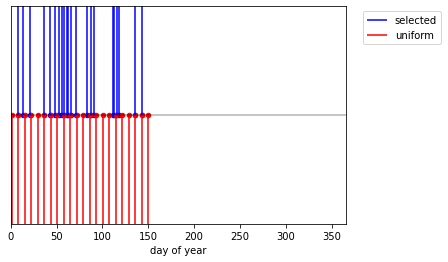

In [57]:
start_doy = get_doy("%s%s" % (year, date_range[0]))
end_doy = get_doy("%s%s" % (year, date_range[1]))
uniform_doy_list = np.linspace(start_doy, end_doy, numproducts).tolist()

doys = df2keep.copy()  # [['datatakesensingstart', 'cloudcoverpercentage', 'size']]
doys['doy'] = pd.DataFrame(
    doys['datatakesensingstart'].apply(lambda s: get_doy(str(s).split(' ')[0].replace('-', ''))))

idx_list = []
for doy_ in uniform_doy_list:
    # print(doy_)
    doys['distance'] = distance(doys, doy_, ccfactor)
    idx = doys['distance'].argmin()
    idx_list.append(pd.DataFrame(doys.iloc[idx, :]).T)
    doys = doys.drop(index=idx).reset_index(drop=True)
prod2keep = pd.concat(idx_list).reset_index(drop=True)  # df2keep.iloc[idx_list].reset_index(drop=True)
prod2keep['doy'] = pd.DataFrame(
    prod2keep['datatakesensingstart'].apply(lambda s: get_doy(str(s).split(' ')[0].replace('-', ''))))

# visualize
plt.scatter(prod2keep['doy'].values, np.zeros(prod2keep.shape[0]), s=20, c='b')
plt.scatter(uniform_doy_list, np.zeros(len(uniform_doy_list)), s=20, c='r')
plt.vlines(prod2keep['doy'].values, 0, 1, color='b', label='selected')
plt.vlines(uniform_doy_list, 0, -1, color='r', label='uniform')
plt.hlines(0, 1, 365, color='k', alpha=0.3)
plt.ylim(-1, 1)
plt.xlim(0, 365)
plt.yticks([], [])
plt.xlabel('day of year')
plt.legend(bbox_to_anchor=(1.3, 1))

# examine
print(prod2keep[['doy', 'size', 'cloudcoverpercentage']])  # .columns)

### Save selected products to disk

In [58]:
savename = '%s/%s_%s_tile%s_minsize%dMb_%ddates_year%s_from%sto%s_mincc%dmaxcc%d.csv' % \
           (savedir, platformname, processinglevel, tile, minprodsize, numproducts, year, 
            date_range[0], date_range[1], cloudcoverpercentage[0], cloudcoverpercentage[1])

if not os.path.exists(os.path.dirname(savename)):
    print("making new directory %s" % os.path.dirname(savename))
    os.makedirs(os.path.dirname(savename))

print("saving products info to %s" % savename)
prod2keep.to_csv(savename, index=False)

making new directory /media/michaeltrs/0a8a5a48-ede5-47d0-8eff-10d11350bf98/Satellite_Data/Sentinel2/Germany/S2_products/T32UPV/2021
saving products info to /media/michaeltrs/0a8a5a48-ede5-47d0-8eff-10d11350bf98/Satellite_Data/Sentinel2/Germany/S2_products/T32UPV/2021/Sentinel-2_Level-1C_tile32UPU_minsize400Mb_22dates_year2021_from0101to0530_mincc0maxcc70.csv
